C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54480 entries, 2019-01-01 00:00:00 to 2025-03-19 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Consumption    54151 non-null  float64
 1   Production     54151 non-null  float64
 2   Nuclear        54151 non-null  float64
 3   Wind           54151 non-null  float64
 4   Hydroelectric  54151 non-null  float64
 5   Oil and Gas    54151 non-null  float64
 6   Coal           54151 non-null  float64
 7   Solar          54151 non-null  float64
 8   Biomass        54151 non-null  float64
dtypes: float64(9)
memory usage: 4.2 MB
None

Head:
                     Consumption  Production  Nuclear   Wind  Hydroelectric  \
DateTime                                                                      
2019-01-01 00:00:00       6352.0      6527.0   1395.0   79.0         1383.0   
2019-01-01 01:00:00       6116.0      5701.0   1393.0   96.0     

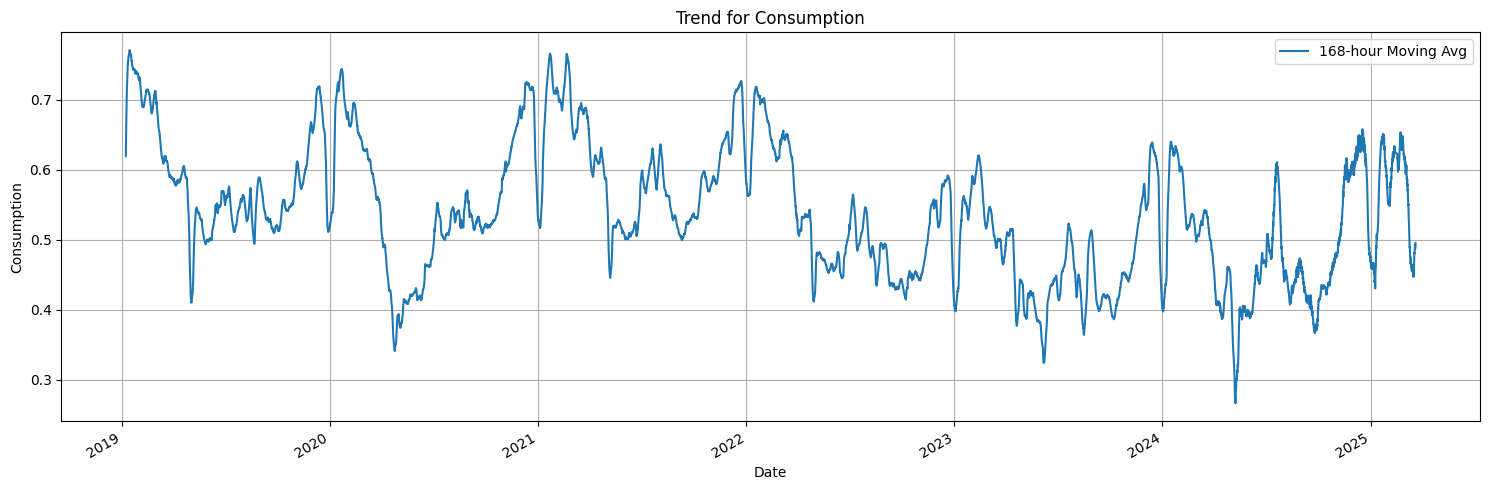

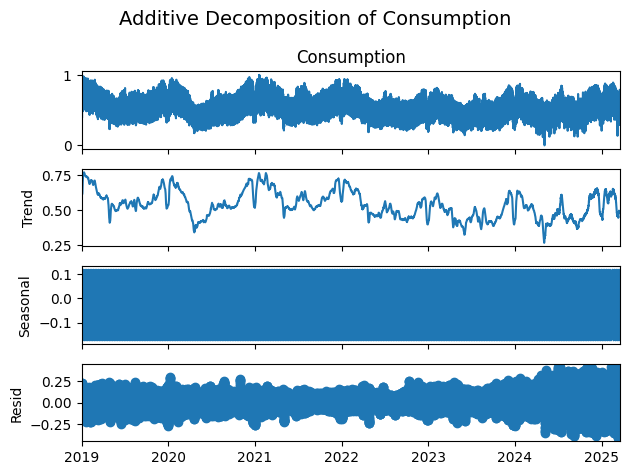

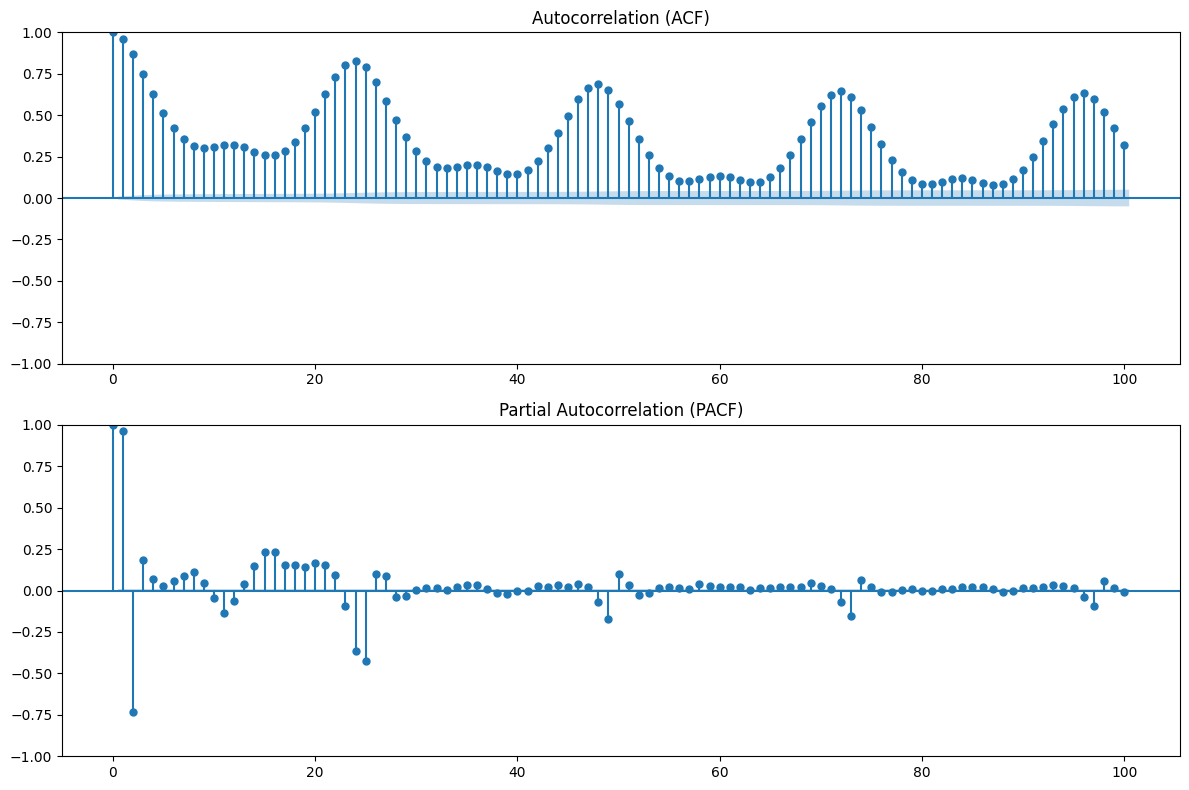

Time-lagged Regression -> MSE: 0.0011, MAE: 0.0203
SARIMAX -> MSE: 0.62, MAE: 0.72


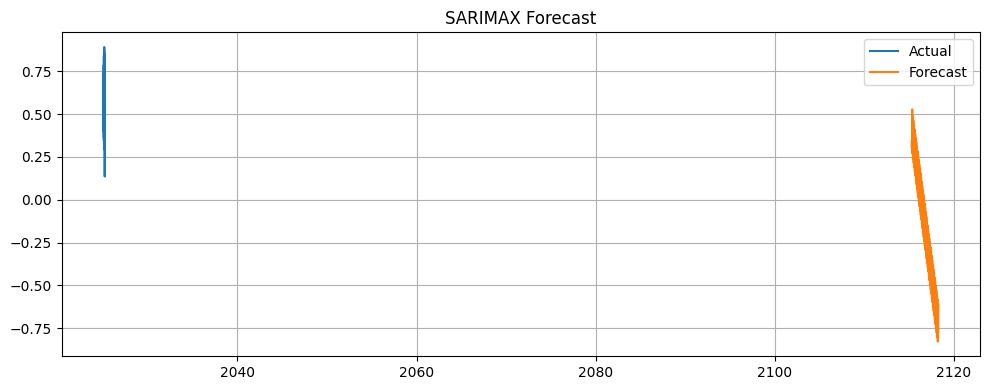

22:09:59 - cmdstanpy - INFO - Chain [1] start processing
22:10:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MSE: 0.03, MAE: 0.13


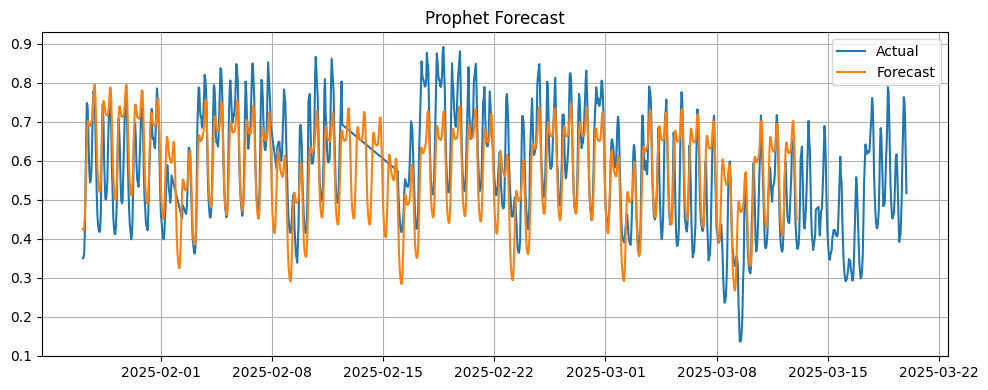

Time-lagged Regression -> MSE: 38703562573852605412678834114391392940579927612343784114993017795903488.00, MAE: 26158961165793572460190989096583168.00


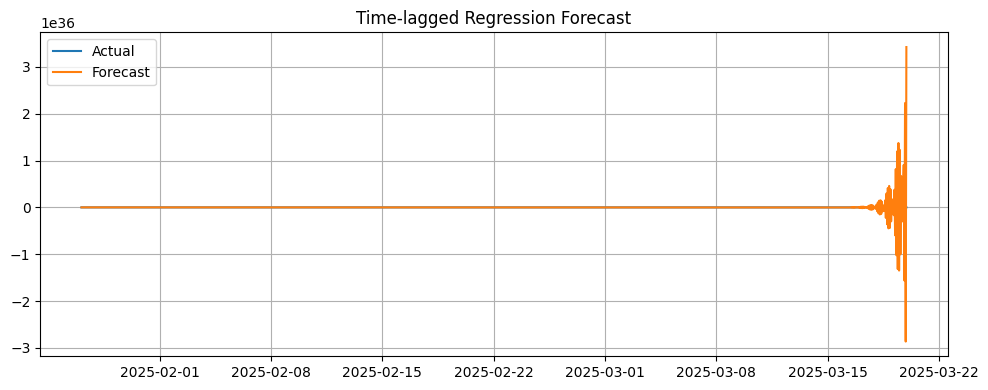

Chronos-Bolt eror.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class DataInspector:
    def __init__(self):
        dt_path = "electricity_consumption_and_production.csv"
        self.df = pd.read_csv(dt_path)
        self.df['DateTime'] = pd.to_datetime(self.df['DateTime'])
        if 'DateTime' not in self.df.columns:
            raise ValueError("Колонка 'DateTime' не знайдена у датафреймі!")
        self.df = self.df.drop_duplicates(subset='DateTime', keep='first')
        self.df.set_index('DateTime', inplace=True)
        self.df = self.df.asfreq('H')

    def view(self):
        print('Data Info:')
        print(self.df.info())
        print('\nHead:')
        print(self.df.head())
        print('\nMissing:')
        print(self.df.isnull().sum())
        print("Available columns:", self.df.columns.tolist())

    def plot(self):
        self.df['Consumption'].plot(figsize=(15, 4), title='Electricity Consumption')
        plt.show()

    def get_df(self):
        return self.df


class Dt_split:
    def __init__(self, df, forecast_day=45):
        self.df = df
        self.forecast_horizon = forecast_day * 24
        self.train = df.iloc[:-self.forecast_horizon]
        self.test = df.iloc[-self.forecast_horizon:]

    def get_split(self):
        return self.train, self.test, self.forecast_horizon



class PreprocessingCleaner:
    def __init__(self, df):
        self.original_df = df.copy()
        self.df = None
        self.scaler = MinMaxScaler()

    def clean_and_scale(self):
        self.df = self.original_df.dropna()
        self.df.loc[:, :] = self.scaler.fit_transform(self.df)

        print(f"Пропущені значення видалено. Залишилось {len(self.df)} записів.")
        return self.df, self.scaler


class ExploratoryDataAnalysis:
    def __init__(self, df, column='Consumption'):
        self.df = df
        self.column = column
        self.series = df[column]

    def plot_trend(self, window=24 * 7):  # тижневе середнє за годинами
        plt.figure(figsize=(15, 5))
        self.series.rolling(window=window).mean().plot(label=f'{window}-hour Moving Avg')
        plt.title(f'Trend for {self.column}')
        plt.xlabel('Date')
        plt.ylabel(self.column)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_decomposition(self, model='additive', freq=24 * 7):
        result = seasonal_decompose(self.series, model=model, period=freq)
        result.plot()
        plt.suptitle(f'{model.capitalize()} Decomposition of {self.column}', fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_acf_pacf(self, lags=50):
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(self.series.dropna(), lags=lags, ax=ax[0])
        plot_pacf(self.series.dropna(), lags=lags, ax=ax[1])
        ax[0].set_title('Autocorrelation (ACF)')
        ax[1].set_title('Partial Autocorrelation (PACF)')
        plt.tight_layout()
        plt.show()

class TimeSeriesModels:
    def __init__(self, df, column, horizon):
        self.df = df
        self.column = column
        self.horizon = horizon
        self.train = df[:-horizon]
        self.test = df[-horizon:]
        self.results = {}

    def evaluate(self, y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        self.results[model_name] = {'MSE': mse, 'MAE': mae}
        print(f"{model_name} -> MSE: {mse:.2f}, MAE: {mae:.2f}")

    def plot_forecast(self, actual, predicted, title):
        plt.figure(figsize=(10, 4))
        plt.plot(actual.index, actual.values, label='Actual')
        plt.plot(predicted.index, predicted.values, label='Forecast')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run_sarimax(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)):
        model = SARIMAX(self.train[self.column], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.forecast(steps=self.horizon)
        self.evaluate(self.test[self.column], forecast, "SARIMAX")
        self.plot_forecast(self.test[self.column], forecast, "SARIMAX Forecast")

    def run_prophet(self):
        df_prophet = self.train[[self.column]].reset_index().rename(columns={'DateTime': 'ds', self.column: 'y'})
        model = Prophet(daily_seasonality=True)
        model.fit(df_prophet)

        future = model.make_future_dataframe(periods=self.horizon, freq='H')
        forecast = model.predict(future)

        y_pred = forecast.set_index('ds')['yhat'][-self.horizon:]
        y_true = self.test[self.column]
        self.evaluate(y_true, y_pred, "Prophet")
        self.plot_forecast(y_true, y_pred, "Prophet Forecast")

    def run_time_lagged_regression(self, n_lags=24):
        df_lagged = self.train[[self.column]].copy()
        for lag in range(1, n_lags + 1):
            df_lagged[f'lag_{lag}'] = df_lagged[self.column].shift(lag)
        df_lagged.dropna(inplace=True)

        X = df_lagged.drop(self.column, axis=1).values
        y = df_lagged[self.column].values

        model = LinearRegression().fit(X, y)

        last_values = self.train[self.column].iloc[-n_lags:].values
        preds = []
        for _ in range(self.horizon):
            x_input = last_values[-n_lags:]
            pred = model.predict([x_input])[0]
            preds.append(pred)
            last_values = np.append(last_values, pred)

        index = self.test.index
        y_pred = pd.Series(preds, index=index)
        self.evaluate(self.test[self.column], y_pred, "Time-lagged Regression")
        self.plot_forecast(self.test[self.column], y_pred, "Time-lagged Regression Forecast")

    def run_chronos_bolt(self):
        try:
            from bigdl.chronos.model.bolt import TCNForecaster
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaled_train = scaler.fit_transform(self.train[[self.column]])
            y_train = scaled_train

            model = TCNForecaster(past_seq_len=24, future_seq_len=self.horizon, input_feature_num=1, output_feature_num=1)
            model.fit(x=scaled_train[:-self.horizon], y=y_train[24:])

            y_pred_scaled = model.predict(scaled_train[-24:])
            y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            y_pred = pd.Series(y_pred, index=self.test.index)

            self.evaluate(self.test[self.column], y_pred, "Chronos-Bolt")
            self.plot_forecast(self.test[self.column], y_pred, "Chronos-Bolt Forecast")

        except ImportError:
            print("Chronos-Bolt eror.")



class TimeLaggedRegression:
    def __init__(self, df, target_column='Consumption', lags=24):
        self.df = df
        self.target_column = target_column
        self.lags = lags
        self.model = LinearRegression()

    def create_lagged_features(self):
        df_lagged = self.df[[self.target_column]].copy()
        for lag in range(1, self.lags + 1):
            df_lagged[f'lag_{lag}'] = df_lagged[self.target_column].shift(lag)
        df_lagged.dropna(inplace=True)
        return df_lagged

    def train_test_split(self, df_lagged, test_size=0.1):
        split_idx = int(len(df_lagged) * (1 - test_size))
        train = df_lagged.iloc[:split_idx]
        test = df_lagged.iloc[split_idx:]
        return train, test

    def fit(self):
        df_lagged = self.create_lagged_features()
        train, test = self.train_test_split(df_lagged)
        X_train = train.drop(columns=[self.target_column])
        y_train = train[self.target_column]
        X_test = test.drop(columns=[self.target_column])
        y_test = test[self.target_column]

        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f'Time-lagged Regression -> MSE: {mse:.4f}, MAE: {mae:.4f}')

        return y_test, y_pred


start_dt = DataInspector()
start_dt.view()

df = start_dt.get_df()
start_split = Dt_split(df)
train, test, horizon = start_split.get_split()

clean = PreprocessingCleaner(start_dt.df)
cleaned_df, scaler = clean.clean_and_scale()

eda = ExploratoryDataAnalysis(cleaned_df, column='Consumption')
eda.plot_trend()
eda.plot_decomposition()
eda.plot_acf_pacf(lags=100)

lagged_model = TimeLaggedRegression(cleaned_df, target_column='Consumption', lags=24)
y_test, y_pred = lagged_model.fit()

tsm = TimeSeriesModels(cleaned_df, column='Consumption', horizon=horizon)
tsm.run_sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
tsm.run_prophet()
tsm.run_time_lagged_regression(n_lags=24)
tsm.run_chronos_bolt()

